# Annotation Cost Estimates

This notebook explores the estimated costs (time / effort / money) of annotating the Open-MIC project, exploring a number of variables.

- [Mechanical Turk Model](#Mechanical-Turk-Model)
- [Crowdsourcing Model](#Crowdsourcing-Model)

In [1]:
%matplotlib inline
import numpy as np
import tabulate
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

**Parameters**
* $L$ – Target number of completed tasks
* $N$ – Total number of users
* $\nu$ – A given user
* $\epsilon_{\nu}$ – The number of tasks (effort) completed by a user
* $\epsilon_{max}$ – Effort expended by the "most" involved user
* $P(\nu = \epsilon~|~\alpha)$ – Power-law distribution of user effort
* $\alpha \in (0, \infty)$ – Power-law distribution parameter
 * $\alpha < 1$ : biased toward 0, most users do little
 * $\alpha == 1$ : uniform, all users are equal
 * $\alpha > 1$ : biased toward 1, most users do a lot
* $t$ – Real time
* $\mu_t$ – Average task completion in real-time
* $\tau$ – Task time
* $\mu_\tau$ – Average task completion time

* $\omega_{t}$ – The wall clock "rate" at which a user complete tasks, e.g. $\frac{\epsilon}{t}$
* $\omega_{\tau}$ – The "rate" at which a user completes tasks, e.g. $\frac{\epsilon}{\tau}$
* $T_\epsilon$ – Average wall clock time per task, over all users
* $T_\epsilon$ – Average completion time per task, over all users
* $\mu_\rho$ – Average effort redundancy per "done" label


* $c$ – Cost per unit effort, in USD

**Observed Outputs**
- $\sum (\epsilon~|~M, N, c, \rho)$ -- Total effort to complete
- Total cost to completion
- Count(t)
- Count($)
- Effort(t)
- Effort(#)

## Mechanical Turk Model
[back to top](#Annotation-Cost-Estimates)

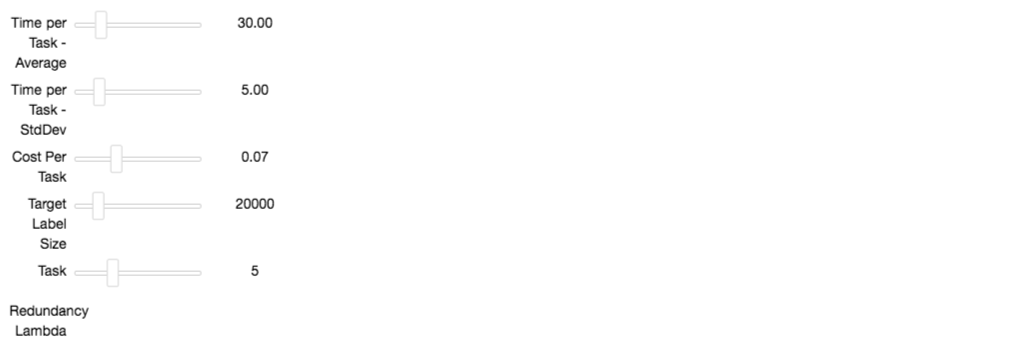

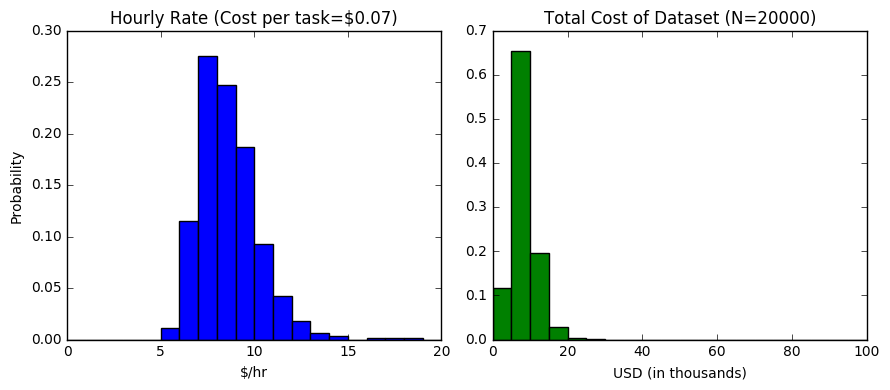

In [2]:
# Mech Turk Model
N_trials = 1000

# Factors we can control
# ----------------------
cost_per_task = widgets.FloatSlider(
    value=0.07, min=0.01, max=0.20, step=0.01,
    description='Cost Per Task', orientation='horizontal',
    readout=True, readout_format='.2f', slider_color='white')

target_count = widgets.IntSlider(
    value=20000, min=5000, max=100000, step=100,
    description='Target Label Size',
    continuous_update=False, orientation='horizontal',
    readout=True, readout_format='i', slider_color='white')

# Distributional factors we can guess
# -----------------------------------
# Task Completion
time_per_task_mu = widgets.FloatSlider(
    value=30, min=10, max=120, step=1,
    description='Time per Task - Average',
    orientation='horizontal',readout=True,
    readout_format='.2f', slider_color='white')

time_per_task_std = widgets.FloatSlider(
    value=5, min=0.001, max=30, step=0.5,
    description='Time per Task - StdDev',
    orientation='horizontal',
    readout=True, readout_format='.2f', slider_color='white')

# Task Redundancy
tasks_per_label = widgets.IntSlider(
    value=5, min=1, max=15, step=1,
    description='Task Redundancy - Lambda',
    continuous_update=False, orientation='horizontal',
    readout=True, readout_format='i', slider_color='white')

# Dependent Variables
# -------------------
def turk_data(tpt_mu, tpt_sig, cpt, tc, tpl):
    time_per_task = np.random.normal(loc=tpt_mu, 
                                     scale=tpt_sig, size=N_trials)
    tasks_per_hour = (3600. / time_per_task)
    hourly_rate = cpt * tasks_per_hour
    base_cost = tc * cpt
    task_multiplier = np.random.poisson(tpl, size=N_trials) + 1
    total_cost = base_cost * task_multiplier / 1000.
    hr_bins, hr_edges = np.histogram(hourly_rate, bins=20, range=(0, 20))
    cost_bins, cost_edges = np.histogram(total_cost, bins=20, range=(0, 100))
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    ax[0].bar(hr_edges[:-1], hr_bins / hr_bins.sum(),
              width=np.diff(hr_edges)[-1])
    ax[0].set_ylabel("Probability")
    ax[0].set_xlabel("$/hr")
    ax[0].set_title("Hourly Rate (Cost per task=${:0.2f})".format(cpt))
    ax[1].bar(cost_edges[:-1], cost_bins / cost_bins.sum(), 
              width=np.diff(cost_edges)[-1], fc='green')
    ax[1].set_title("Total Cost of Dataset (N={})".format(tc))
    ax[1].set_xlabel("USD (in thousands)")
    plt.tight_layout()
    plt.show()

display(widgets.interactive(turk_data, tpt_mu=time_per_task_mu, 
                            tpt_sig=time_per_task_std, cpt=cost_per_task,
                            tc=target_count, tpl=tasks_per_label))

In [3]:
def user_effort(duration, max_tau_weekly, alpha, min_tau, size):
    """Draw samples from an "effort" distribution, in units of seconds.
    
    The time spent by a user is a function of:
     - When they start the campaign (assumed uniform)
     - Amount that they stay involved over time (power-law)
     - The likelihood that they care (power-law)
     - An upper bound on their weekly output
    
    Parameters
    ----------
    duration : float
        Duration of the campaign, in days.
    
    max_tau : float
        Max time effort per week, in minutes.
    
    n : int
        Number of samples to draw.
    
    Returns
    -------
    effort : np.ndarray, shape=size
        Work effort produced, in seconds.
    """
    days_active = np.round(1 + duration * np.random.power(np.power(1.0/duration, .2), 
                                                          size=size))
    daily_effort = 60 * max_tau_weekly * np.random.power(alpha, size=size) / 7.0
    daily_effort[daily_effort < min_tau] = min_tau
    return daily_effort * days_active

## Crowdsourcing Model
[back to top](#Annotation-Cost-Estimates)

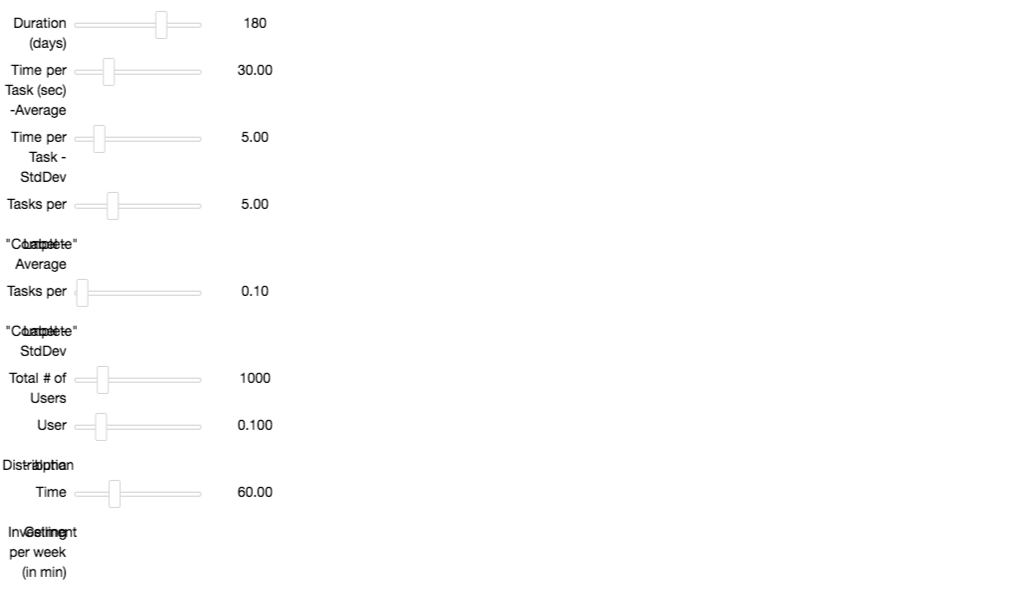

Time Investment (hr): mu=0.899, max=25.713, max_weekly=1.000
Total tasks: 111174.752
    by user: mu=111.174752 max=6075.0
Total Labels: mu=22248.273


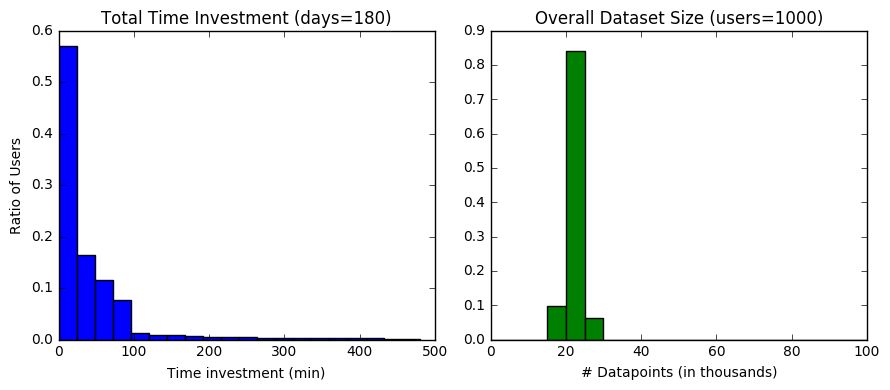

In [4]:
# Crowdsourced Model
N_trials = 1000

# Factors we can control
# ----------------------
duration = widgets.IntSlider(
    value=180, min=10, max=250, step=1, description='Duration (days)',
    readout=True, readout_format='i', slider_color='white')

# Distributional factors we can guess
# -----------------------------------
# Task Completion - in seconds
time_per_task_mu = widgets.FloatSlider(
    value=30, min=10, max=90, step=1,
    description='Time per Task (sec) - Average',
    orientation='horizontal',readout=True,
    readout_format='.2f', slider_color='white')

time_per_task_sig = widgets.FloatSlider(
    value=5, min=0.001, max=30, step=0.25,
    description='Time per Task - StdDev',
    orientation='horizontal',
    readout=True, readout_format='.2f', slider_color='white')

# Task Redundancy
tasks_per_label_mu = widgets.FloatSlider(
    value=5, min=1, max=15, step=0.1,
    description='Tasks per "Complete" Label - Average',
    orientation='horizontal',readout=True,
    readout_format='.2f', slider_color='white')

tasks_per_label_sig = widgets.FloatSlider(
    value=0.1, min=0.001, max=5, step=0.1,
    description='Tasks per "Complete" Label - StdDev',
    orientation='horizontal',
    readout=True, readout_format='.2f', slider_color='white')

user_count = widgets.IntSlider(
    value=1000, min=10, max=5000, step=5, description='Total # of Users',
    readout=True, readout_format='i', slider_color='white')

user_alpha = widgets.FloatSlider(
    value=0.1, min=0.01, max=0.5, step=0.01,
    description='User Distribution - alpha',
    orientation='horizontal',
    readout=True, readout_format='.3f', slider_color='white')

# Upper bound on invested annotation time, per week, in min
max_tau_week = widgets.FloatSlider(
    value=60, min=0.5, max=200, step=1,
    description='Time Investment Ceiling per week (in min)',
    orientation='horizontal',
    readout=True, readout_format='.2f', slider_color='white')

kwargs = dict(
    duration=duration, 
    time_per_task_mu=time_per_task_mu, 
    time_per_task_sig=time_per_task_sig, 
    tasks_per_label_mu=tasks_per_label_mu,
    tasks_per_label_sig=tasks_per_label_sig,
    user_count=user_count, 
    user_alpha=user_alpha, 
    max_tau_week=max_tau_week)

# Dependent Variables
# -------------------
def crowd_data(duration, time_per_task_mu, 
               time_per_task_sig, tasks_per_label_mu, 
               tasks_per_label_sig, user_count, user_alpha, 
               max_tau_week):
    
    # Sampled in seconds.
    time_investment = user_effort(
        duration, max_tau_week, user_alpha, 
        min_tau=time_per_task_mu, size=(user_count, N_trials))

    # Sample of time-investment over the campaign, in hours
    print("Time Investment (hr): mu={:.3f}, max={:.3f}, max_weekly={:.3f}"
          .format(time_investment.mean() / 3600, 
                  time_investment.max() / 3600,
                  time_investment.max() / 3600 / duration * 7))
    
    # Observed time per task, in seconds
    time_per_task = np.random.normal(
        loc=time_per_task_mu, scale=time_per_task_sig, 
        size=time_investment.shape)
    
    # Aggregate over users, shape=(n_trials,)
    tasks = np.round(time_investment / time_per_task)
    total_tasks = tasks.sum(axis=0)
    print("Total tasks: {}".format(total_tasks.mean()))
    print("    by user: mu={} max={}".format(tasks.mean(), tasks.max()))
    task_redundancy = np.random.normal(
        tasks_per_label_mu, tasks_per_label_sig, size=N_trials)
    # Must be at least 1
    task_redundancy[task_redundancy < 1] = 1.0
    total_labels = total_tasks / task_redundancy
    print("Total Labels: mu={:.3f}".format(total_labels.mean()))
    
    # Total Time Investment per user - pdf
    tti_bins, tti_edges = np.histogram(
        time_investment.flatten() / 60, 
        bins=20, range=(0, 60*8))
    
    # Total Labels - pdf
    tl_bins, tl_edges = np.histogram(
        total_labels / 1000., bins=20, range=(0, 100))
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    ax[0].bar(tti_edges[:-1], tti_bins / tti_bins.sum(),
              width=np.diff(tti_edges)[-1])
    ax[0].set_ylabel("Ratio of Users")
    ax[0].set_xlabel("Time investment (min)")
    ax[0].set_title("Total Time Investment (days={:d})".format(duration))
    
    ax[1].bar(tl_edges[:-1], tl_bins / tl_bins.sum(), 
              width=np.diff(tl_edges)[-1], fc='green')
    ax[1].set_title("Overall Dataset Size (users={})".format(user_count))
    ax[1].set_xlabel("# Datapoints (in thousands)")
    plt.tight_layout()
    plt.show()

display(widgets.interactive(crowd_data, **kwargs))